<a href="https://colab.research.google.com/github/MarinoLizzy/simplecell/blob/main/Single_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following cell is based off of a study from Tiesinga et al. in 2005 titled "Inhibitory synchrony as a mechanism for attentional gain modulation."

Here is a link to this open-access paper: https://pubmed.ncbi.nlm.nih.gov/16274973/

Biological studies have found that visual stimuli in a neuron's receptive field will cause more action potentials to fire in those neurons if the stimulus is the focus of attention. Tiesinga et al. propose that synchrony of involved inhibitory interneurons is the mechanism by which attention causes more activity in neurons.

To demonstrate this possible mechanism in a computational model, we will generate a train of spikes that represents input from multiple inhibitory interneurons into a single pyramidal neuron. We will modulate the variance of this input train to represent different levels of synchrony in the inhibitory input, and graph this input in figure 1.

Either run each code block (in order) or click "Runtime" –> "Run all" at the top of the page.

In [2]:
#@title Import Necessary Files and Libraries
import os, sys
from io import StringIO
RunningInCOLAB = 'google.colab' in str(get_ipython())

%cd /content

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
  if RunningInCOLAB:
      print('Downloading packages')
      !pip install NEURON==8.2.2
      # !pip install bmtk==0.0.9
      !pip install ipywidgets==7.7.1

  if os.path.basename(os.getcwd())!='simplecell':
      !git clone https://github.com/MarinoLizzy/simplecell.git
      %cd simplecell
      !nrnivmodl Modfiles
      #%cd Modfiles
      %ls

print("Downloading model this will only take a min!")
import neuron
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

/content


In [3]:
#@title Generate Inhibitory Input Spikes
def gaussian_density(x: np.ndarray, mu: float, sigma: float):
    '''
    Purpose: Get the value of gaussian densitiy(mu, sigma) at points x.
    Parameters:
        x: (np.ndarray) Values to compute density at.
        mu: (float) Mean of the gaussian.
        sigma: (float) Standard deviation of the gaussian.
    Returns:
        out: (float) The gaussian densitiy(mu, sigma) at points x.
    '''
    # return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x-mu)**2) / (2 * sigma**2))
    return (1/(np.sqrt(2*np.pi*sigma**2))) * np.exp(-((x-mu)**2) / (2*sigma**2))


def generate_spike_times():
    '''
    Purpose: To generate spike volley times based on P (mean interval) and CV_t (coefficient of variance)
    Values:
        spike_volleys (array): timestamps of the mean of each spike volley
        STP_x (list of arrays):
        STP_gaus (list of floats): a Gaussian curve for each spike volley
        spike_probs (list): flattened version of STP_x and STP_gaus
        spike_times (list of floats): timestamps of each individual spike
        flat_x: a flattened version of STP_x
    Output (list): [flat_x, volley_trace, spike_probs, spike_trace, spike_times]
    '''
    spike_volleys = np.zeros(num_spike_volleys) #Generates an empty array that's the size of the number of spike volleys
    for i in range(1, len(spike_volleys)): #Fills the spike_volleys array with spike times - what you see in fig 1a
        spike_volleys[i] = spike_volleys[i - 1] + np.random.normal(P, CV_t * P)

    # Define and apply Gaussian filter w/ length of 40ms, centered around spike volleys
    STP_x = [] #spike time probability
    STP_gaus = []
    spike_probs = []

    for v_time in range(1, len(spike_volleys) - 1):
        gaus_start = (spike_volleys[v_time] + spike_volleys[v_time - 1]) / 2 #avg time of two spike volleys, on the left side
        gaus_end = (spike_volleys[v_time] + spike_volleys[v_time + 1]) / 2 #avg time of two spike volleys, on the right side
        x_length = int(gaus_end - gaus_start + 1)
        x = np.linspace(gaus_start, gaus_end, x_length) #calculates x_length evenly-spaced samples between gaus_start and gaus_end

        if (spike_volleys[v_time] > sigma_start) and (spike_volleys[v_time] < sigma_end): #sigma_iv is 8ms before 300 and after 700. It is 2ms within this interval
            gaus = gaussian_density(x, spike_volleys[v_time], sigma_IV_inside) #generating Gaussian curves (as defined above)
        else:
            gaus = gaussian_density(x, spike_volleys[v_time], sigma_IV_outside)


        STP_x.append(x)
        STP_gaus.append(gaus)

    if figure == 1: #it needs to be normalized for figures 2 and 3, but not for 1
        flat_x = [x for volley in STP_x for x in volley]
        flat_gaus = [gaus for volley in STP_gaus for gaus in volley]

        spike_probs.append(np.array(flat_gaus) / np.max(flat_gaus))

        spike_probs = [prob for volley in spike_probs for prob in volley]

        volley_trace = np.zeros_like(flat_x)
        for i in range(1, len(spike_volleys) - 1):
            volley_trace[np.argmin(np.abs(flat_x - spike_volleys[i]))] = 1
    else:
        # Flatten into 1D arrays for plotting
        flat_x = [x for volley in STP_x for x in volley]
        spike_probs = []
        for volley in STP_gaus:
            spike_probs.extend((volley / np.max(volley)).tolist())

        volley_trace = np.zeros_like(flat_x)
        for i in range(1, len(spike_volleys) - 1):
            volley_trace[np.argmin(np.abs(flat_x - spike_volleys[i]))] = 1

    # Generate spike times using Poisson process
    spike_times = []
    for i in range(len(flat_x)):
        if np.random.uniform() <= spike_probs[i]:
            spike_times.append(i)

    spike_trace = np.zeros_like(flat_x)
    spike_trace[spike_times] = 1

    return flat_x, volley_trace, spike_probs, spike_trace, spike_times

In [4]:
#@title Build the Cell
'''Building Soma'''
h.load_file('nrngui.hoc')
h.load_file('stdrun.hoc')
h.dt = 0.01  # ms Timestep as stated in page 4 of the Tiesinga paper (same as their bin width)
h.v_init = -65  # mV Initial membrane potential

soma = h.Section(name='soma')

# ** = from calculations based on Fellous et al. 2010
soma.L = 79.788  # soma length µm  **
soma.diam = 79.788  # soma diameter µm  **
soma.cm = 1  # membrane capacitance µF/cm2
soma.Ra = 100  # ohm-cm  **

soma.insert('leak')  # Leak channel, using the .mod file
soma.glbar_leak = 0.1 / 1000 #0.0001  # S/cm2
soma.el_leak = -65  # mV

soma.insert('na')  # Sodium channel, using the .mod file
soma.gnabar_na = 35 / 1000 #0.035  # S/cm2
soma.ena = 55 # mV

soma.insert('k')  # Potassium channel, using the .mod file
soma.gkbar_k = 9 / 1000 #0.009  # S/cm2
soma.ek = -90 # mV

surface_area = np.pi * soma.L * soma.diam * 10**-8 #cm^2


'''Spike Volley Parameters'''
P = 26.10 #ms mean time (ms) between spike volleys, from appendix fig 2
CV_t = 0.095 #Coefficient of variance calculated as sqrt(var/mean), from appendix fig 2.

#Where the spike train enters into the cell
spike_input = h.ExpSyn(soma(0.5))  # Inhibitory synapse into the middle of the cell
spike_input.tau = 10 # (ms) decay time constant, as per fig.s  2-10 in the appendix of Tiesinga
spike_input.e = -75 # (mV) reversal potential, from pg. 3 of Tiesinga, this is the Erev for a GABA synapse

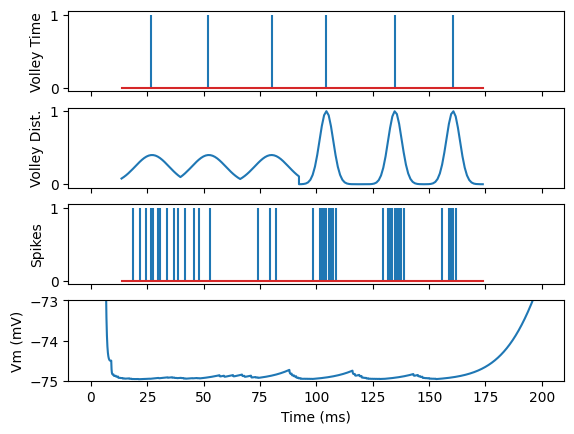

In [5]:
#@title Graph Figure 1

'''1!!!'''
runtime = 200 #ms
sigma_start = 0 #ms
sigma_end = 100 #ms (halfway through the simulation)
sigma_IV_inside = 7.5
sigma_IV_outside = 3
num_spike_volleys = 8 #the number of spike volleys generated
current = 4
netcon_weight = 0.5
figure = 1

flat_x_1, volley_trace_1, spike_probs_1, spike_trace_1, spike_times_1 = generate_spike_times()

spike_input = h.ExpSyn(soma(0.5)) #synapse into the middle of the cell
spike_input.tau =  10 # ms decay time constant, as per fig.s  2-10 in the appendix of Tiesinga
spike_input.e = -75 #mV reversal potential, from pg. 3 of Tiesinga, this is the Erev for a GABA synapse
spike_input.i = current * 1000 * surface_area # nA synaptic current, calculated from fig 2 in appendix A.4

vecstim_1 = h.VecStim() # Uses the vecevent.mod file
vecstim_1.play(h.Vector(spike_times_1))
netcon_1 = h.NetCon(vecstim_1, spike_input)
netcon_1.weight[0] = netcon_weight

t_vec = h.Vector().record(h._ref_t)
v_vec = h.Vector().record(soma(0.5)._ref_v)
h.tstop = runtime # ms
h.run()

fig_1, axs_1 = plt.subplots(nrows = 4, ncols = 1, sharex = True)
axs_1[0].stem(flat_x_1, volley_trace_1, markerfmt = ' ')
axs_1[0].set_ylabel('Volley Time')
axs_1[1].plot(flat_x_1, spike_probs_1)
axs_1[1].set_ylabel('Volley Dist.')
axs_1[2].stem(flat_x_1, spike_trace_1, markerfmt = ' ')
axs_1[2].set_ylabel('Spikes')
axs_1[3].plot(t_vec, v_vec)
axs_1[3].set_ylim([-75, -73])
axs_1[3].set_xlabel('Time (ms)')
axs_1[3].set_ylabel('Vm (mV)')
plt.savefig('colab1')
plt.show()
plt.close()

The above graph shows the inputted inhibitory spikes:

1) The mean of each spike "volley," or train of spikes that is inputted into our single cell.

2) The volley distribution. How wide or narrow (the amount of variance) this graph is represents the synchrony of inputted spikes.

3) Each vertical line represents an individual spike.

4) The membrane voltage of the single cell.


Next, we will input an excitatory current into the cell to get it to spike. This represents background excitatory input. To represent attention on the visual stimulus, we will make the inhibitory inputs more synchronized for part of the simulation. We can then observe the effects of attention on the spiking of the neuron.

Changed dt


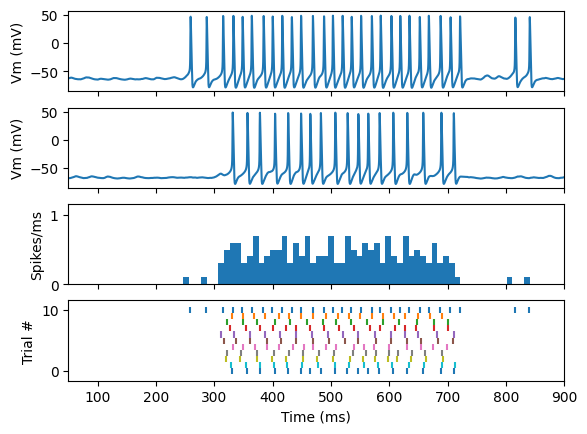

In [5]:
#@title Graph Figure 2
'''2!'''
num_spike_volleys = 40
sigma_start = 300
sigma_end = 700
sigma_IV_outside = 8
sigma_IV_inside = 2
figure = 2
runtime = 900
num_trials = 11
current = 4 # (uA/cm2) from fig 2 in appendix A.4. For 2a it's 4, for 2b it's 1


'''insert the spike train via an inhibitory synapse'''
spike_input = h.ExpSyn(soma(0.5))  # Inhibitory synapse into the middle of the cell
spike_input.tau = 10 # (ms) decay time constant, as per fig.s  2-10 in the appendix of Tiesinga
spike_input.e = -75 # (mV) reversal potential, from pg. 3 of Tiesinga, this is the Erev for a GABA synapse

'''Add an excitatory background current via a current clamp'''

# surface_area = (np.pi * soma.diam ** 2 + 2 * np.pi * (soma.diam / 2)**2) / 10 ** 8 # (cm2)
current_inj = h.IClamp(soma(0.5)) #injected into the middle of the soma
current_inj.delay = 0 # (ms) To check the dynamics
current_inj.dur = runtime # (ms), 900 for fig 2
current_inj.amp = current * surface_area * 1000 #nA calculated from fig 2 in appendix A.4

'''Running and graphing multiple trials'''
#Trial 1 will be plotted as graph a
#Trials 1-10 will be included in the raster plot
#Trial 11 will have a lowered current injection and be plotted as graph b

fig, axs = plt.subplots(nrows=4, sharex=True)
raster_spikes = []
colors1 = [f'C{i}' for i in range(num_trials)]

for i in range(num_trials):
    if i == 10:
        current_inj = None
        current = 1 # (uA/cm2) from fig 2 in appendix A.4. For 2a it's 4, for 2b it's 1
        # surface_area = (np.pi * soma.diam ** 2 + 2 * np.pi * (soma.diam / 2)**2) / 10 ** 8 # (cm2)
        current_inj = h.IClamp(soma(0.5)) #injected into the middle of the soma
        current_inj.delay = 0 # (ms) To check the dynamics
        current_inj.dur = 900 # (ms), 50ms after the last spike occurs
    netcon = None #clear the h.NetCon object
    vecstim = None
    flat_x, volley_trace, spike_probs, spike_trace, spike_times = generate_spike_times()
    vecstim = h.VecStim() # Uses the vecevent.mod file
    vecstim.play(h.Vector(spike_times))
    netcon = h.NetCon(vecstim, spike_input)
    netcon.weight[0] = 0.044 * surface_area * 1000 # (uS - the default units for netcon.weight, stated here: https://www.neuron.yale.edu/phpBB/viewtopic.php?t=1187)
    #^given by Tiesinga as 0.044 mS/cm^2 0.044 * surface area(cm^2) * 1000

    t_vec = h.Vector().record(h._ref_t)  # hoc object, Time stamp vector
    v_vec = h.Vector().record(soma(0.5)._ref_v)  # hoc object, Membrane potential vector

    # Run the simulation
    h.tstop = runtime
    h.run()

    '''Recording when spikes occur'''
    output_t = [] #list with output spike times
    c = 0  # a counter to make sure we only count each spike once

    for j in range(len(t_vec) - 1): #Subtract 1 to not include the final trial where we decrease the current inj
        if v_vec[j] > 0 and c == 0:
            output_t.append(t_vec[j])
            c = 1
        elif v_vec[j] < 0:
            c = 0
    raster_spikes.append(output_t)

    # plot first spikes
    if i == 0:
        axs[0].plot(np.array(t_vec), np.array(v_vec), color=colors1[i])

    if i == 10:
        axs[1].plot(np.array(t_vec), np.array(v_vec), color = colors1[i])

raster_spikes.reverse()
colors1.reverse()
axs[-1].eventplot(raster_spikes, colors=colors1)
# plt.savefig('fig2_abd')

'''Bin Plots (but they're bar graphs right now, we can change later)'''
combined_rasters = []
for trial in raster_spikes:
    for spike in trial:
        combined_rasters.append(spike)

# print(combined_rasters)
# print()

bin_x_vals_1 = [i for i in range(0, runtime + 1, 10)] #bin time is 10 ms
bin_spike_counts = []
for bin_time in range(len(bin_x_vals_1) - 1):
    spike_ctr = 0
    for spike in combined_rasters:
        if bin_x_vals_1[bin_time] <= spike <= bin_x_vals_1[bin_time + 1]:
            spike_ctr += 1
    bin_spike_counts.append(spike_ctr / 10)

bin_x_vals_1 = bin_x_vals_1[:-1]
axs[2].hist(bin_x_vals_1, weights=bin_spike_counts, bins=len(bin_x_vals_1))
axs[0].set_ylabel('Vm (mV)')
axs[1].set_ylabel('Vm (mV)')
axs[2].set_ylabel('Spikes/ms')
axs[3].set_ylabel('Trial #')
axs[3].set_xlabel('Time (ms)')
plt.xlim(50, 900)
# plt.savefig('colab2')
plt.show()
plt.close()

This figure shows:
1) Membrane potential of the cell.

2) Local field potential of the cell, which would be recorded from outside of the cell instead of inside of the cell in biological studies. Here, it's shown as the membrane potential of the cell when the inhibitory input is lowered from 4 to 1 µA/cm^2.

3) Average spikes per ms over 10 trials.

4) A raster plot of the output spike times of the cell across 10 different trials.

As you can see, the cell generates many more action potentials in response to the same excitatory current during the time period 300 < t < 700.


Next, we will determine if this effect remains true even when there are multiple excitatory inputs. In addition to the constant current clamp, we will also inject continuous spikes via an excitatory (glutamatergic) synapse. Again, we will measure membrane voltage, local field potential, and individual spike times. We will again represent attention through increased inhibitory synchrony during 1000 < t < 2000.

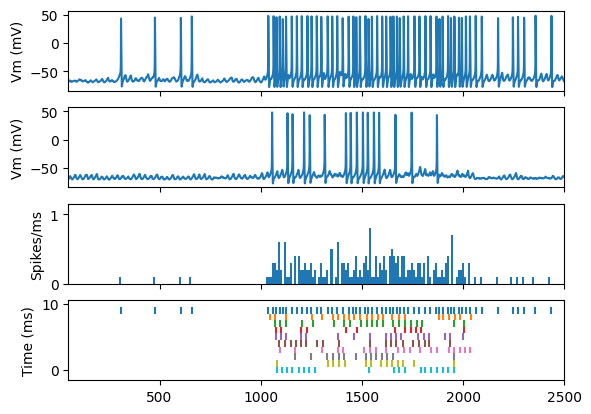

In [6]:
#@title Graph Figure 3
'''3!!!!!'''
sigma_IV_inside = 2
sigma_IV_outside = 4
sigma_start = 1000
sigma_end = 2000
num_spike_volleys = 100
current = 2.4
runtime = 2500
netcon_weight = 0.11 * surface_area * 1000
figure = 3
num_trials = 10 #Change this number to 500 to show the full plot from Tiesinga et al.

''' "There was also a temporally homogeneous excitatory input with rate λexc = 1000 Hz, Δgexc = 0.02 mS/cm2 and τexc = 2 ms. " '''
#generate time stamps, 2500ms long, with a rate of 1000 Hz
excitatory_inputs_in_seconds = np.linspace(0, 2.5, 2501)  # Generate time array from 0 to 2.5 seconds with 2501 points (freq of 1000 Hz)
excitatory_inputs = excitatory_inputs_in_seconds * 1000  # Convert time to milliseconds

excitatory_input = h.ExpSyn(soma(0.5))
#Since this is an excitatory input, it should be glutamate, which has an Erev of 0 mV - https://pubmed.ncbi.nlm.nih.gov/6112722/
excitatory_input.e = 0 #mV
excitatory_input.tau = 2 #ms

#Insert this excitatory input through a netcon object, where we specify the weight (delta_g_exc) and the input
exc_vecstim = h.VecStim() # Uses the vecevent.mod file
exc_vecstim.play(h.Vector(excitatory_inputs))
netcon_exc = h.NetCon(exc_vecstim, excitatory_input)
netcon_exc.weight[0] = 0.02 * surface_area * 1000

current_inj = None
current_inj = h.IClamp(soma(0.5)) #injected into the middle of the soma
current_inj.delay = 0 # (ms) To check the dynamics
current_inj.dur = 2500 # (ms), 50ms after the last spike occurs
current_inj.amp = current * surface_area * 1000

fig, axs = plt.subplots(nrows=4, sharex=True)
raster_spikes = []
colors1 = [f'C{i}' for i in range(10)]

for i in range(num_trials + 1):
    if i == num_trials:
        current_inj = None
        current = -2 # (uA/cm2) from fig 2 in appendix A.4. For 2a it's 4, for 2b it's 1
        # surface_area = (np.pi * soma.diam ** 2 + 2 * np.pi * (soma.diam / 2)**2) / 10 ** 8 # (cm2)
        current_inj = h.IClamp(soma(0.5)) #injected into the middle of the soma
        current_inj.delay = 0 # (ms) To check the dynamics
        current_inj.dur = 2500 # (ms), 50ms after the last spike occurs
    netcon = None #clear the h.NetCon object
    vecstim = None
    flat_x, volley_trace, spike_probs, spike_trace, spike_times = generate_spike_times()
    vecstim = h.VecStim() # Uses the vecevent.mod file
    vecstim.play(h.Vector(spike_times))
    netcon = h.NetCon(vecstim, spike_input)
    netcon.weight[0] = 0.11 * surface_area * 1000 # (uS - the default units for netcon.weight, stated here: https://www.neuron.yale.edu/phpBB/viewtopic.php?t=1187)
    #^given by Tiesinga as 0.044 mS/cm^2 0.044 * surface area(cm^2) * 1000

    t_vec = h.Vector().record(h._ref_t)  # hoc object, Time stamp vector
    v_vec = h.Vector().record(soma(0.5)._ref_v)  # hoc object, Membrane potential vector

    # Run the simulation
    h.tstop = runtime
    h.run()

    if i == 0:
        axs[0].plot(np.array(t_vec), np.array(v_vec), color=colors1[i])

    if i == num_trials:
        axs[1].plot(np.array(t_vec), np.array(v_vec))

    '''Recording when spikes occur'''
    output_t = [] #list with output spike times
    c = 0  # a counter to make sure we only count each spike once

    for j in range(len(t_vec) - 1): #Subtract 1 to not include the final trial where we decrease the current inj
        if v_vec[j] > 0 and c == 0:
            output_t.append(t_vec[j])
            c = 1
        elif v_vec[j] < 0:
            c = 0
    raster_spikes.append(output_t)

graphed_raster_spikes = raster_spikes[:10]
graphed_raster_spikes.reverse()
colors1.reverse()
axs[-1].eventplot(graphed_raster_spikes, colors=colors1)
axs[-1].axhline(y = 0, color = 'r', linestyle = '-', xmin = 1000, xmax = 2000) #TODO: this isn't showing up

combined_rasters = []
for trial in raster_spikes:
    for spike in trial:
        combined_rasters.append(spike)

bin_x_vals_1 = [i for i in range(0, 2501, 10)]
bin_spike_counts = []
for bin_time in range(len(bin_x_vals_1) - 1):
    spike_ctr = 0
    for spike in combined_rasters:
        if bin_x_vals_1[bin_time] <= spike <= bin_x_vals_1[bin_time + 1]:
            spike_ctr += 1
    bin_spike_counts.append(spike_ctr / 10)

bin_x_vals_1 = bin_x_vals_1[:-1]

axs[2].hist(bin_x_vals_1, weights=bin_spike_counts, bins=len(bin_x_vals_1))
axs[0].set_ylabel('Vm (mV)')
axs[1].set_ylabel('Vm (mV)')
axs[2].set_ylabel('Spikes/ms')
axs[3].set_ylabel('Trial #')
axs[3].set_ylabel('Time (ms)')
plt.xlim(50, 2500)
# plt.savefig('colab3')
plt.show()
plt.close()

Again, this figure shows:

1) Membrane potential

2) Local field potential, represented as decreasing the current of the current clamp.

3) Average spikes per ms across 10 trials. Change the number of trials on line 12 of the above code block to show more trials (though the code will take longer to run).

4) A raster plot of output spikes from 10 trials.